# Understanding diagnostic tests

25 August 2021

---

This notebook explains the meaning of different diagnostic test statistics, how they are derived, and why they are used in different contexts.

Sensitivity and specificity can change due to spectrum bias (?)

Reference:

https://www.ncbi.nlm.nih.gov/books/NBK557491/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2683447/

https://www.bmj.com/content/353/bmj.i3139

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

sns.set()
%matplotlib inline

## Useful functions

In [111]:
def positive_predictive_value(y, y_pred):
    """
    Calculate the Positive Predictive Value (PPV)
    from some predicted labels and true labels
    
    This is the probability that a patient has a disease given that
    they test positive for the disease.
    """
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    ppv = tp / (tp + fp)
    return ppv

def negative_predictive_value(y, y_pred):
    """
    Calculate the Negative Predictive Value (PPV)
    from some predicted labels and true labels
    
    This is the probability that a patient does not have the disease 
    given that they test negative for the disease.
    """
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    npv = tn / (tn + fn)
    return npv

def sensitivity(y, y_pred):
    """
    Calculate the sensitivity of a test from the predicted
    and true labels
    
    This is the probability that a patient with the disease
    is correctly identified by the test
    """
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    return sensitivity

def specificity(y, y_pred):
    """
    Calculate the specificity of a test from the predicted
    and true labels
    
    This is the probability that a patient without the disease
    is correctly identified by the test
    """
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

def calculate_scores(X):
    # standardize the data so that x between 0 and 1
    x_min, x_max = X.min(), X.max()
    x_range = x_max - x_min
    X = (X - x_min) / x_range
    return X

def likelihood_ratios(y, y_pred):
    sens = sensitivity(y, y_pred)
    spec = specificity(y, y_pred)
    
    plr = sens / (1 - spec)
    nlr = (1 - sens) / spec
    
    return plr, nlr

def generate_sample_data(population_size=2048, prevalence=0.1):
    num_positive = int(prevalence * population_size)
    num_negative = population_size - num_positive
    
    x1 = 0.5*np.random.randn(num_negative)
    x2 = 0.5*np.random.randn(num_positive) + 1
    y1 = np.zeros(x1.shape)
    y2 = np.zeros(x2.shape) + 1
    
    X = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    
    return X, y

## Generate some sample data

In [172]:
X, y = generate_sample_data(population_size=8192, prevalence=0.1)

In [173]:
X0 = X[np.where(y == 0)]
X1 = X[np.where(y == 1)]

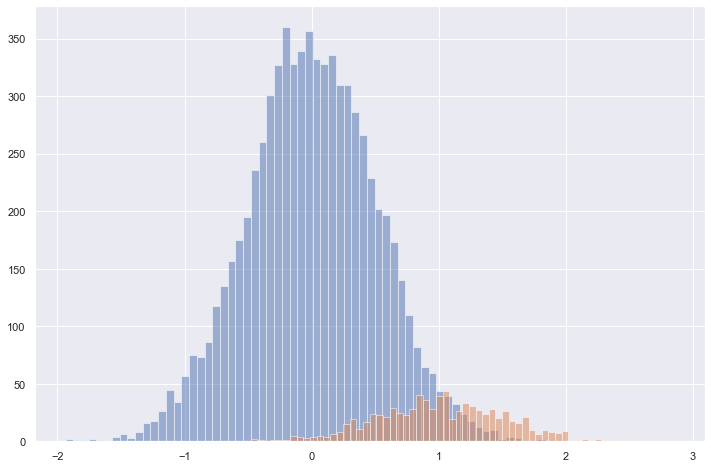

In [174]:
plt.figure(figsize=(12, 8))
plt.hist(X0, bins=64, alpha=0.5)
plt.hist(X1, bins=64, alpha=0.5)
plt.show()

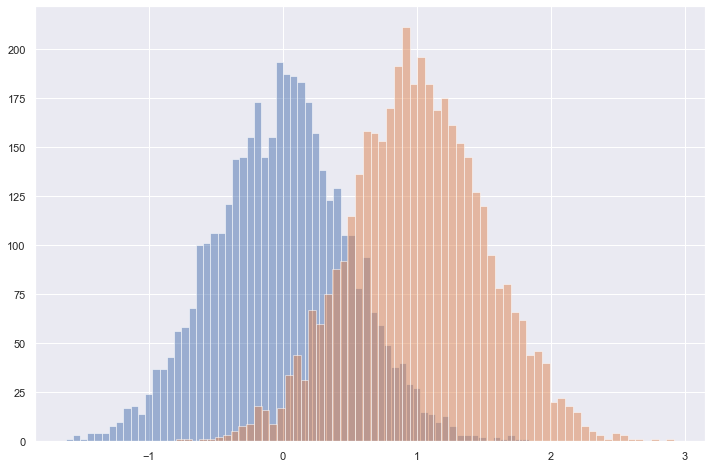

In [176]:
X, y = generate_sample_data(population_size=8192, prevalence=0.5)

X0 = X[np.where(y == 0)]
X1 = X[np.where(y == 1)]

plt.figure(figsize=(12, 8))
plt.hist(X0, bins=64, alpha=0.5)
plt.hist(X1, bins=64, alpha=0.5)
plt.show()

## Define the test

Say that patient is positive if value > 1 and negative if < 1

In [177]:
threshold = 0.75

y_pred = (X > threshold).astype(int)
y_score = calculate_scores(X)

## Calculate stats from test

For a given threshold:
- PPV, NPV
- FP, FN, TP, TN
- PLR, NLR, DOR
- Sensitivity, Specificity

For arbitrary thresholds:
- ROC, AUC

In [178]:
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
tn, fp, fn, tp

(3828, 268, 1228, 2868)

In [179]:
positive_predictive_value(y, y_pred), negative_predictive_value(y, y_pred)

(0.9145408163265306, 0.757120253164557)

In [180]:
sensitivity(y, y_pred), specificity(y, y_pred)

(0.7001953125, 0.9345703125)

In [181]:
fpr, tpr, thresholds = roc_curve(y, y_score)
auc = roc_auc_score(y, y_score)

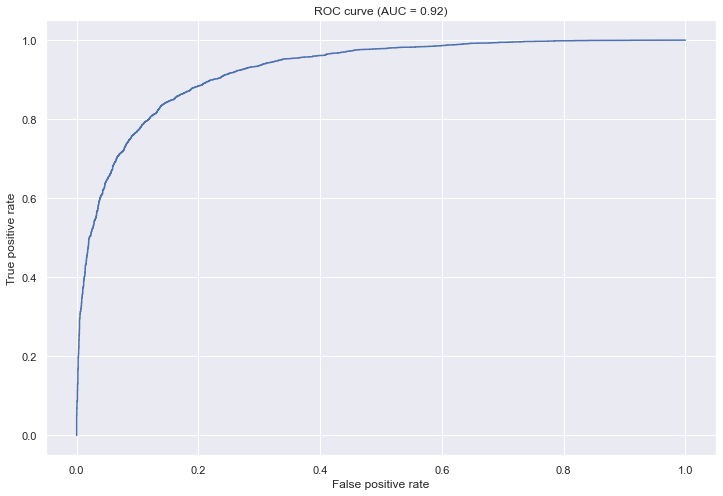

In [182]:
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve (AUC = {np.round(auc, 2)})')
plt.show()

## Why are some of these statistics sensitive to the prevalence of the disease?

PPV, NPV, Sensitivity and Specificity are sensitivity to the prevalence of the disease, i.e., the proportion of the population that actually has the diease. PLR, NLR and DOR on the other hand, are not.

This example shows why this is the case.

In [183]:
# for a given threshold, how do the stats vary with different prevalence fractions?
prevalences = np.arange(0.05, 1, 1/20)

In [184]:
stats = []

for prevalence in prevalences:
    X, y = generate_sample_data(population_size=2048, prevalence=prevalence)
    threshold = 0.75
    y_pred = (X > threshold).astype(int)
    y_score = calculate_scores(X)
    ppv, npv = positive_predictive_value(y, y_pred), negative_predictive_value(y, y_pred)
    sens, spec = sensitivity(y, y_pred), specificity(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    plr, nlr = likelihood_ratios(y, y_pred)
    stats.append((tn, fp, fn, tp, ppv, npv, sens, spec, plr, nlr))

## Positive and negative predictive values

These are affected by the prevalence of the disease; PPV increases with prevalence while NPV decreases.

Why is this?

- PPV = P(D | H_1) * N_1 / (P(D | H_1) * N_1 + P(D | H_0) * N_0)
- The probabilities do not change but there is a dependence on the absolute numbers of positive and negative cases

More intuitively (an example):
- Given 1000 people and a prevalence of 5%, e.g., 50 out of 1000 are positive, 9950 are negative.
- Suppose a false positive rate of 5% for test, e.g., 5% of 9950 are positive, e.g., around 498 test positive who are not.
- What is the PPV? I.e., probability that if someone tests positive they are positive?
- 50 / (498 + 50) probability of being positive.

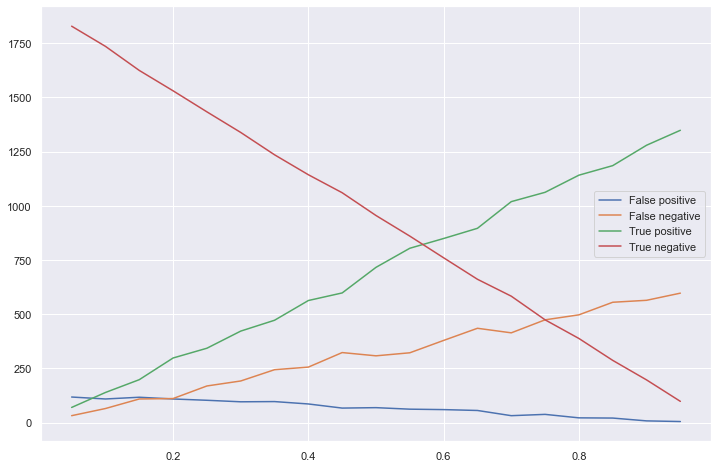

In [185]:
# plot the stats vs prevalences
tns = list(zip(*stats))[0]
fps = list(zip(*stats))[1]
fns = list(zip(*stats))[2]
tps = list(zip(*stats))[3]

plt.figure(figsize=(12, 8))
plt.plot(prevalences, fps, label='False positive')
plt.plot(prevalences, fns, label='False negative')
plt.plot(prevalences, tps, label='True positive')
plt.plot(prevalences, tns, label='True negative')
plt.legend(loc='right')
plt.show()

In [186]:
# plot the stats vs prevalences
ppvs = list(zip(*stats))[4]
npvs = list(zip(*stats))[5]

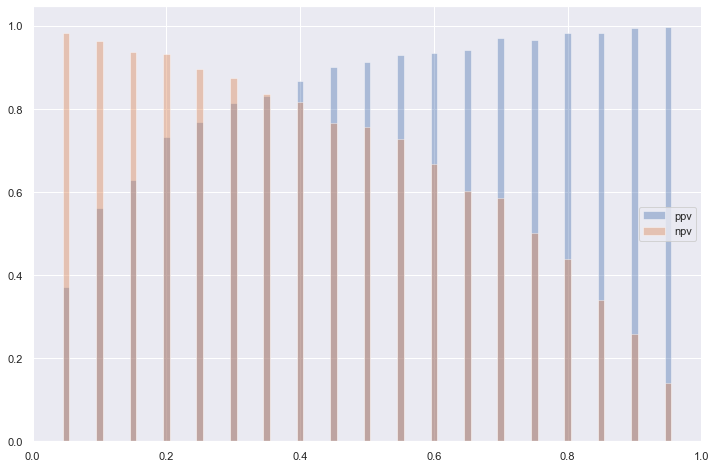

In [187]:
plt.figure(figsize=(12, 8))
plt.bar(x=prevalences, height=ppvs, width=0.01, alpha=0.4, label='ppv')
plt.bar(x=prevalences, height=npvs, width=0.01, alpha=0.4, label='npv')
plt.legend(loc='right')
plt.show()

## Sensitivity and specificity

These are independent of the disease prevalence. Why?

These are proportions of each of the distributions (distribution of the positive cases and distribution of the negative cases)

Sensitivity: what proportion of positive cases are above a certain value (defined by the threshold)

Specificity: what proporiton of negative cases are below a certain value (defined by the threshold)

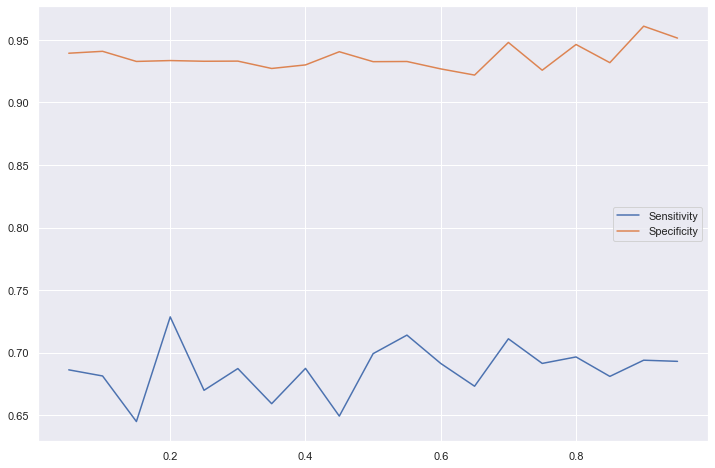

In [188]:
# plot the stats vs prevalences
sens = list(zip(*stats))[6]
spec = list(zip(*stats))[7]

plt.figure(figsize=(12, 8))
plt.plot(prevalences, sens, label='Sensitivity')
plt.plot(prevalences, spec, label='Specificity')
plt.legend(loc='right')
plt.show()

## Positive and negative likelihood ratios

These are not affected by the prevalence of the disease in the population as can be seen in the graph below.

What is the intuition for this?
- Apply Bayes' theorem to the sensitivity -> PPV
- The sensitivity is independent of the prevalence, but P(D) (the probability of someone having a the disease, i.e., the prevalence) mutiplies this.

Positive Likelihood Ratio: True positive rate / false positive rate

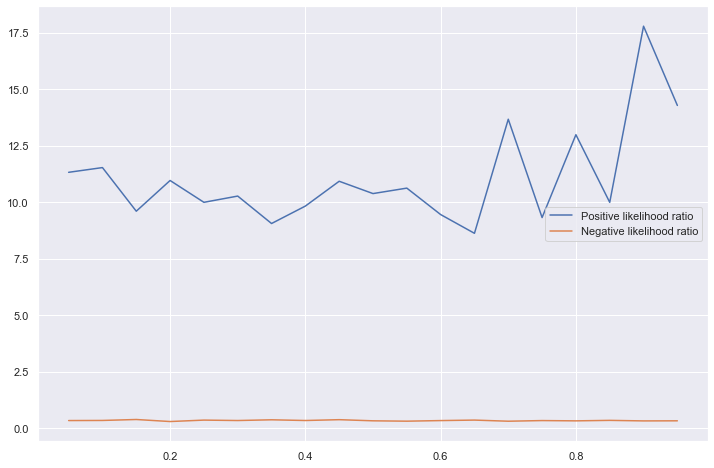

In [189]:
plrs = list(zip(*stats))[8]
nlrs = list(zip(*stats))[9]

plt.figure(figsize=(12, 8))
plt.plot(prevalences, plrs, label='Positive likelihood ratio')
plt.plot(prevalences, nlrs, label='Negative likelihood ratio')
plt.legend(loc='right')
plt.show()

## Where disease is not dichotomous

The above is when the disease status can be defined in a binary way (either a person has the disease or does not) but some diseases are defined (?) in terms of the value of a measurement. E.g., hypertension being defined as systolic blood pressure being above 150mmHg.

For these cases, the sensitivity, specificity, likelihood ratios and many other measures vary with the prevalence of the disease in the population.

### Simulated data

Following https://www.bmj.com/content/353/bmj.i3139, this can be shown by representing the prevalence of the disease within a population by the proportion of the population that is above a certain threshold.

How are false positives, negatives defined in this context?